In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from model import FusionDenoiser

In [3]:
torch.backends.cudnn.benchmark = False

In [4]:
torch.manual_seed(43)
np.random.seed(43)

In [5]:
def tens2img(tensor):
    '''Move the axes of a 3D Tensor such that it can be plotted as an image'''
    return np.moveaxis(tensor.detach().cpu().numpy(), 0,-1)

# Dataset

The class FocalDataset loads grayscale images from a dataset folder.

The parameters 'input_channels' and 'output_channels' control how many times the grayscale values are repeated as extra channels, separately for the model input and model output.

For random data augmentation, effectively increasing our training data, set 'augment' to True. This should be off for validation and test datasets, to ensure consistent evaluation.

The parameter 'normalize' changes the pixel value range from [0,255] to [0,1], which is likely advantageous. As I'm not completely sure though, there's the option to turn it off.

In [6]:
from dataset import FocalDataset

In [7]:
ds = FocalDataset(input_channels=3, output_channels=3, augment=True, normalize=True)

In [8]:
stack, gt = ds[0]

In [9]:
stack.shape

torch.Size([8, 3, 512, 512])

In [10]:
gt.shape

torch.Size([3, 512, 512])

Text(0.5, 1.0, 'Ground Truth')

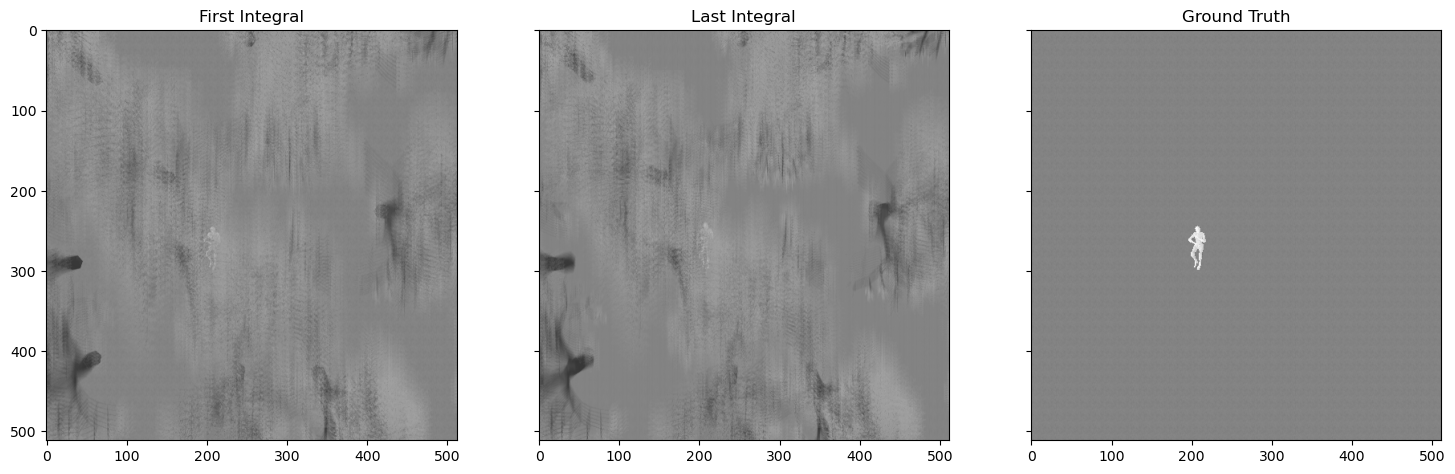

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18,10), sharey=True)

axes[0].imshow(tens2img(stack[0]), cmap='gray')
axes[1].imshow(tens2img(stack[-1]), cmap='gray')
axes[2].imshow(tens2img(gt), cmap='gray')

axes[0].set_title('First Integral')
axes[1].set_title('Last Integral')
axes[2].set_title('Ground Truth')

## DataLoader

The DataLoader wraps around a dataset and gives it additional functionality.

Specifically, it gathers the separate samples provided by the dataset into batches, for more efficient GPU usage.

It also allows for random shuffling of samples, which helps the model to train smoothly. Don't use this for validation/testing though, as we need consistent results.

In [12]:
batch_size = 2
train_dl = torch.utils.data.DataLoader(ds,
                                       batch_size=batch_size,
                                       shuffle=True,     # only for training set!
                                       num_workers=0,    # could be useful to prefetch data while the GPU is working
                                       pin_memory=True)  # should speed up CPU to GPU data transfer

In [13]:
# train_dl would usually be used in a for loop, e.g. "stack, gt in train_dl", but we just get a single sample here for demonstration
stack, gt = next(iter(train_dl))

In [14]:
stack.shape  # batch, n_focal_lengths, channels, dim1, dim2

torch.Size([2, 8, 3, 512, 512])

# Model

There are many different parameters to control the model, most of which are not used here yet but should be played around with.

The two in use here choose the newer Swin Version and activate the "low V-Ram" execution, decreasing memory usage but increasing training time.

In [15]:
model = FusionDenoiser(swin_version='V2', use_checkpoint=True, depths=[5]*5, num_heads=[5]*5)
model = model.cuda()   # move the model to gpu

In [16]:
stack = stack.cuda(non_blocking=True)  # move data to the gpu. non_blocking=True in combination with pin_memory in the dataloader leads to async data transfer, which can speed it up
fused, denoised = model(stack)   # feed the input to the network

In [17]:
fused.shape   # 'fused' is the result of fusing our image stack into a single image. This output is only useful to sate curiosity of what the model does

torch.Size([2, 1, 512, 512])

In [18]:
denoised.shape  # 'denoised' is the final model prediction. it should be used to calculate metrics and losses

torch.Size([2, 1, 512, 512])

Text(0.5, 1.0, 'Denoised')

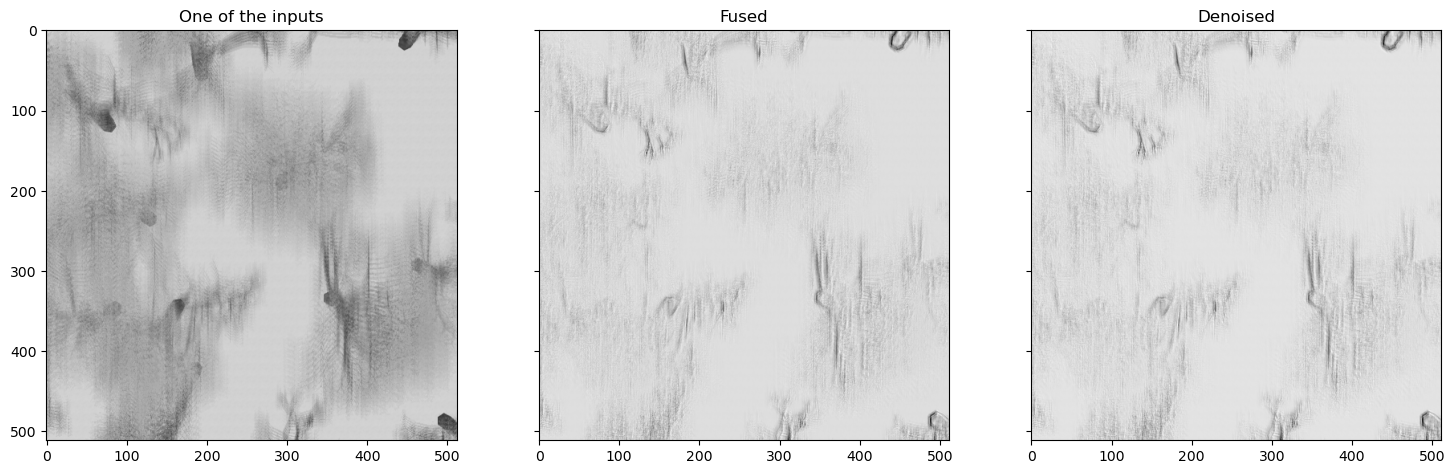

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18,10), sharey=True)

axes[0].imshow(tens2img(stack[0,0]), cmap='gray')
axes[1].imshow(tens2img(fused[0]), cmap='gray')
axes[2].imshow(tens2img(denoised[0]), cmap='gray')

axes[0].set_title('One of the inputs')
axes[1].set_title('Fused')
axes[2].set_title('Denoised')